# Imports e Configurações

In [10]:
%pip install pandas numpy seaborn matplotlib mlflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from mlflow.models.signature import infer_signature


# Configurações visuais
sns.set_style("whitegrid")

TRAIN_INPUT_FILE_PATH = '../data/test.csv' 
TEST_INPUT_FILE_PATH = '../data/test.csv' 

# Caminho de saída para o dataset amostrado
OUTPUT_PATH_TRAIN = '../data/generated/train_chunk.csv'
OUTPUT_PATH_TEST = '../data/generated/test_chunk.csv'

# Tamanho da amostra desejada (balanceada)
SAMPLES_PER_CLASS_TRAIN = 50 * 1000 
SAMPLES_PER_CLASS_TEST = 5 * 1000
RANDOM_SEED = 99

SKIP_TUNNING = False
CACHED_TUNNING_PARAMS = {}

print("Ambiente configurado.")

Ambiente configurado.


# Limpeza dos dados

In [12]:
def _extract_balanced_from_file(file_path, samples_needed, label_map):
    """
    Função interna que lê um arquivo específico em chunks e extrai amostras balanceadas.
    """
    print(f"--> Processando arquivo: {file_path}")
    
    data_pos = []
    data_neg = []
    chunk_size = 100000
    chunks_processed = 0
    
    try:
        for chunk in pd.read_csv(file_path, chunksize=chunk_size, header=None, names=['polarity', 'title', 'text']):    
            chunks_processed += 1
            print(f"   Lendo chunk {chunks_processed}...", end='\r')

            chunk = chunk.dropna(subset=["text", "polarity", "title"])
            
            chunk['title'] = chunk['title'].fillna("").astype(str)
            chunk['text'] = chunk['text'].astype(str)
            chunk['polarity'] = chunk['polarity'].astype(int)
            
            if len(data_neg) < samples_needed:
                neg_chunk = chunk[chunk['polarity'] == 1].copy()
                needed = samples_needed - len(data_neg)
                data_neg.extend(neg_chunk[['text','title','polarity']].head(needed).values.tolist())

            if len(data_pos) < samples_needed:
                pos_chunk = chunk[chunk['polarity'] == 2].copy()
                needed = samples_needed - len(data_pos)
                data_pos.extend(pos_chunk[['text','title','polarity']].head(needed).values.tolist())
            
            if len(data_pos) >= samples_needed and len(data_neg) >= samples_needed:
                break
                
        # Monta DataFrame
        df_result = pd.DataFrame(data_pos + data_neg, columns=['text','title','polarity'])
        
        # Embaralha
        df_result = df_result.sample(frac=1, random_state=42).reset_index(drop=True)
        
        return df_result

    except FileNotFoundError:
        print(f"\nERRO: Arquivo {file_path} não encontrado.")
        return pd.DataFrame()

def create_balanced_datasets(train_path, test_path, out_train, out_test, n_train, n_test):
    """
    Orquestrador que gera os dois datasets balanceados.
    """
    print("Iniciando amostragem de TREINO...")
    df_train = _extract_balanced_from_file(train_path, n_train, label_map={1:0, 2:1})
    if not df_train.empty:
        df_train.to_csv(out_train, index=False)
        print(f"\nTreino salvo: {out_train} | Shape: {df_train.shape}")
    
    print("\nIniciando amostragem de TESTE...")
    df_test = _extract_balanced_from_file(test_path, n_test, label_map={1:0, 2:1})
    if not df_test.empty:
        df_test.to_csv(out_test, index=False)
        print(f"\nTeste salvo: {out_test} | Shape: {df_test.shape}")
        
    return df_train, df_test

df_train, df_test = create_balanced_datasets(
    TRAIN_INPUT_FILE_PATH,
    TEST_INPUT_FILE_PATH,
    OUTPUT_PATH_TRAIN,
    OUTPUT_PATH_TEST,
    SAMPLES_PER_CLASS_TRAIN,
    SAMPLES_PER_CLASS_TEST
)

Iniciando amostragem de TREINO...
--> Processando arquivo: ../data/test.csv
   Lendo chunk 4...
Treino salvo: ../data/generated/train_chunk.csv | Shape: (399976, 3)

Iniciando amostragem de TESTE...
--> Processando arquivo: ../data/test.csv
   Lendo chunk 1...
Teste salvo: ../data/generated/test_chunk.csv | Shape: (50000, 3)


# Análise Exploratória (EDA)

/var/folders/mx/th5bgtcn19d079t50rlghdrw0000gp/T/ipykernel_7086/1325083595.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='polarity', data=df_train, palette='viridis', ax=axes[0])
/var/folders/mx/th5bgtcn19d079t50rlghdrw0000gp/T/ipykernel_7086/1325083595.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='polarity', data=df_test, palette='magma', ax=axes[1])


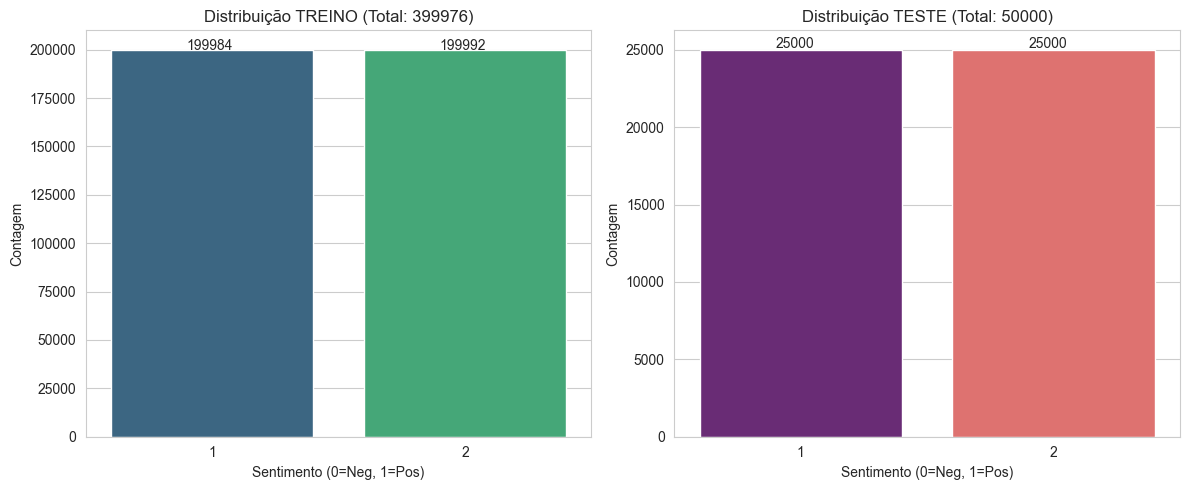

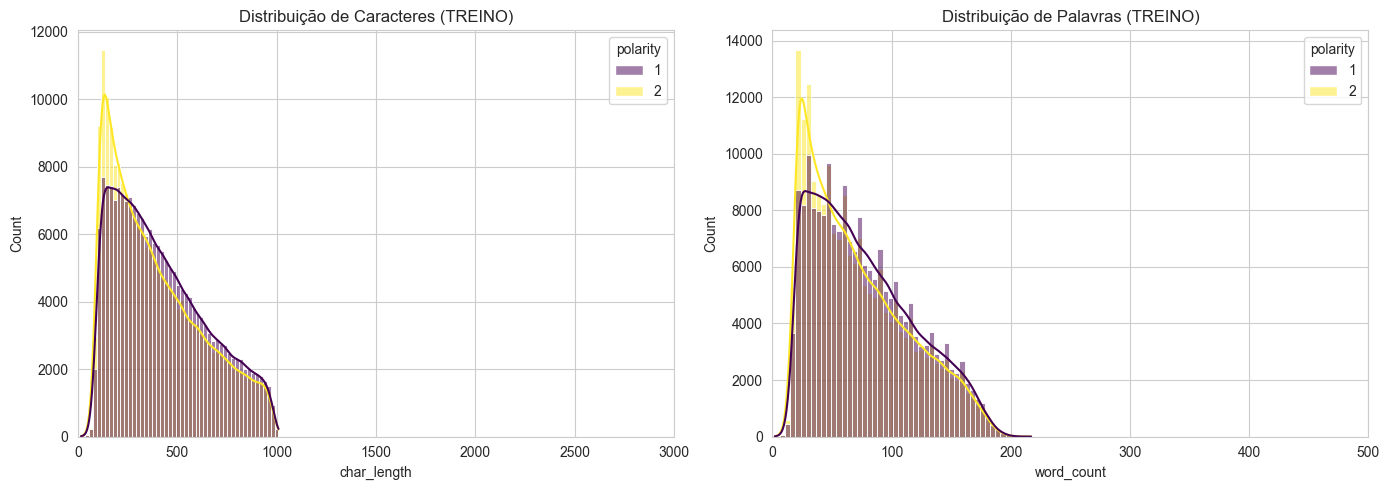


--- Estatísticas de Texto (TREINO) ---
         char_length     word_count
count  399976.000000  399976.000000
mean      404.911890      74.108797
std       234.109671      42.257916
min        15.000000       2.000000
25%       207.000000      39.000000
50%       356.000000      66.000000
75%       565.000000     103.000000
max      1009.000000     217.000000


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Class Distribution (Train vs Test) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train
if not df_train.empty:
    sns.countplot(x='polarity', data=df_train, palette='viridis', ax=axes[0])
    axes[0].set_title(f'Distribuição TREINO (Total: {len(df_train)})')
    axes[0].set_xlabel('Sentimento (0=Neg, 1=Pos)')
    axes[0].set_ylabel('Contagem')
    for p in axes[0].patches:
        axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + 0.3, p.get_height() + 100))

# Test
if not df_test.empty:
    sns.countplot(x='polarity', data=df_test, palette='magma', ax=axes[1])
    axes[1].set_title(f'Distribuição TESTE (Total: {len(df_test)})')
    axes[1].set_xlabel('Sentimento (0=Neg, 1=Pos)')
    axes[1].set_ylabel('Contagem')
    for p in axes[1].patches:
        axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + 0.3, p.get_height() + 100))

plt.tight_layout()
plt.show()

# --- 2. Text Length Analysis (Character Count) ---
# Calculate lengths
if not df_train.empty:
    df_train['char_length'] = df_train['text'].astype(str).apply(len)
    df_train['word_count'] = df_train['text'].astype(str).apply(lambda x: len(x.split()))

if not df_test.empty:
    df_test['char_length'] = df_test['text'].astype(str).apply(len)

plt.figure(figsize=(14, 5))

# Character Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='char_length', hue='polarity', kde=True, bins=50, palette='viridis')
plt.title('Distribuição de Caracteres (TREINO)')
plt.xlim(0, 3000)  # Limit to avoid extreme outliers

# Word Count Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='word_count', hue='polarity', kde=True, bins=50, palette='viridis')
plt.title('Distribuição de Palavras (TREINO)')
plt.xlim(0, 500)

plt.tight_layout()
plt.show()

# --- 3. Basic Statistics ---
print("\n--- Estatísticas de Texto (TREINO) ---")
print(df_train[['char_length', 'word_count']].describe())

# Configurando ambiente de treino

In [14]:
mlflow.set_tracking_uri("http://0.0.0.0:5001") 
mlflow.set_experiment("TCC MLOps")
mlflow.sklearn.autolog()

print("MLflow configurado.")

MLflow configurado.


# Carregando dados processados

In [15]:
def load_dataset(path):
    try:
        df = pd.read_csv(path)

        df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

        # Combina título + texto
        for split in [df_train, df_test]:
            split['combined_text'] = (
                split['title'].astype(str) + " " + split['text'].astype(str)
            )

        X_train = df_train['combined_text']
        y_train = df_train['polarity']
        X_test = df_test['combined_text']
        y_test = df_test['polarity']

        print(f"Dados carregados. Treino: {len(X_train)} | Teste: {len(X_test)}")
        return X_train, y_train, X_test, y_test

    except FileNotFoundError:
        print("ERRO: Arquivo CSV não encontrado. Rode o pré-processamento primeiro.")

X_train, y_train, X_test, y_test = load_dataset(OUTPUT_PATH_TRAIN)

    
X_eval, y_eval, _, _ = load_dataset(OUTPUT_PATH_TEST)


Dados carregados. Treino: 319980 | Teste: 79996
Dados carregados. Treino: 40000 | Teste: 10000


# Loop de Experimentação

## Traning and select the best model

In [16]:
models_to_test = {
    "Naive_Bayes_Baseline": MultinomialNB(),
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "Linear_SVM": LinearSVC(),
    "Random_Forest": RandomForestClassifier(n_estimators=100, max_depth=10)
}

best_score = 0
best_name = None
best_pipe = None

for name, model in models_to_test.items():
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('classifier', model)
    ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    score = f1_score(y_test, pred)

    print(f"[BASE] {name} → F1={score:.4f}")

    if score > best_score:
        best_score = score
        best_name = name
        best_pipe = pipe


2025/11/20 22:59:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e886925835154331ac2a4621a0dc5a3f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/20 22:59:57 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 23:00:28 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


🏃 View run honorable-rook-356 at: http://0.0.0.0:5001/#/experiments/1/runs/e886925835154331ac2a4621a0dc5a3f
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


2025/11/20 23:02:13 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 23:02:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dacce63ccf2a478b9802f58ca9f48cb3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/20 23:02:13 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


[BASE] Naive_Bayes_Baseline → F1=0.8688


2025/11/20 23:02:45 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


🏃 View run judicious-midge-257 at: http://0.0.0.0:5001/#/experiments/1/runs/dacce63ccf2a478b9802f58ca9f48cb3
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


2025/11/20 23:04:31 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 23:04:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cb11f918a866469b9463278d7fead9bd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/20 23:04:31 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


[BASE] Logistic_Regression → F1=0.9088


2025/11/20 23:05:12 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


🏃 View run hilarious-bee-346 at: http://0.0.0.0:5001/#/experiments/1/runs/cb11f918a866469b9463278d7fead9bd
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


KeyboardInterrupt: 

In [ ]:
tuning_strategy_map = {
    "Linear_SVM": {
        "model": LinearSVC(dual='auto', max_iter=2000),
        "param_grid": {
            "classifier__C": [0.1, 1, 10],
            "tfidf__max_features": [5000, 10000],
            "tfidf__ngram_range": [(1, 1), (1, 2)]
        }
    },
    "Logistic_Regression": {
        "model": LogisticRegression(max_iter=2000),
        "param_grid": {
            "classifier__C": [0.1, 1, 10],
            "tfidf__max_features": [5000, 10000]
        }
    },
    "Random_Forest": {
        "model": RandomForestClassifier(),
        "param_grid": {
            "classifier__n_estimators": [50, 100],
            "classifier__max_depth": [10, 20],
            "tfidf__max_features": [5000]
        }
    },
    "Naive_Bayes_Baseline": {  # <<< CORRIGIDO NOME
        "model": MultinomialNB(),
        "param_grid": {
            "classifier__alpha": [0.1, 0.5, 1.0],
            "tfidf__max_features": [5000, 10000]
        }
    }
}


In [ ]:
def evaluate_model(model):
    y_pred_eval = tuned_model.predict(X_eval)
    eval_metrics = {
        "eval_f1": f1_score(y_eval, y_pred_eval),
        "eval_acc": accuracy_score(y_eval, y_pred_eval),
        "eval_precision": precision_score(y_eval, y_pred_eval),
        "eval_recall": recall_score(y_eval, y_pred_eval)
    }
    print("Eval metrics:", eval_metrics)
    # ----- SIGNATURE CORRETA -----
    signature = infer_signature(
        model_input=["exemplo de texto"],
        model_output=[1]   # ou 0
    )
    # Input example correto: LISTA DE STRINGS, não DataFrame
    input_example = ["I love this product"]
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="",   # raiz
        signature=signature,
        input_example=input_example,
        registered_model_name="SentimentAnalysis_Production"
    )
    return model

def tune_model(strategy_name):    
    conf = tuning_strategy_map[strategy_name]
    base_model, param_grid = conf["model"], conf["param_grid"]

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("classifier", base_model)
    ])

    with mlflow.start_run(run_name=f"Tuning_{strategy_name}"):

        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=3,
            scoring="f1",
            n_jobs=-1,
            verbose=1
        )

        # ----- TREINO -----
        grid.fit(X_train, y_train)
        tuned_model = grid.best_estimator_

        print("\nBest Params:", grid.best_params_)
        CACHED_TUNNING_PARAMS = grid.best_params_

        # ----- AVALIAÇÃO -----
        y_pred_eval = tuned_model.predict(X_eval)

        eval_metrics = {
            "eval_f1": f1_score(y_eval, y_pred_eval),
            "eval_acc": accuracy_score(y_eval, y_pred_eval),
            "eval_precision": precision_score(y_eval, y_pred_eval),
            "eval_recall": recall_score(y_eval, y_pred_eval)
        }

        print("Eval metrics:", eval_metrics)

        # ----- SIGNATURE CORRETA -----
        signature = infer_signature(
            model_input=["exemplo de texto"],
            model_output=[1]   # ou 0
        )

        # Input example correto: LISTA DE STRINGS, não DataFrame
        input_example = ["I love this product"]
        mlflow.sklearn.log_model(
            sk_model=tuned_model,
            artifact_path="",   # raiz
            signature=signature,
            input_example=input_example,
            registered_model_name="SentimentAnalysis_Production"
        )

        return tuned_model

if not SKIP_TUNING:
    tune_model(best_name)
else:
    with mlflow.start_run(run_name=f"Tuning_{strategy_name}"):
        print("Skipping tuning")
        evaluate_model(best_model)

2025/11/20 13:12:46 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


2025/11/20 13:12:54 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 13:13:02 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.
2025/11/20 13:13:02 WARNING mlflow.sklearn: Encountered exception during creation of child runs for parameter search. Child runs may be missing. Exception: 'NoneType' object has no attribute '_to_mlflow_entity'



Best Params: {'classifier__C': 1, 'tfidf__max_features': 10000}
Eval metrics: {'eval_f1': 0.9107276819204801, 'eval_acc': 0.91075, 'eval_precision': 0.9139272271016311, 'eval_recall': 0.9075504610017443}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/20 13:13:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 13:13:05 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs

🏃 View run Tuning_Logistic_Regression at: http://0.0.0.0:5001/#/experiments/1/runs/98160c37a6a548768ce2ae417443a2fb
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


,steps,"[('tfidf', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
